## Accessing Sentinel-2 data on Azure

This notebook demonstrates basic access to Sentinel-2 data on Azure, using sentinelsat to query the Copernicus Open Access Hub for tiles, then accessing the tiles on Azure blob storage.  Because Sentinel-2 data are in preview, the user needs to provide storage credentials.

Sentinel-2 data are stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in West Europe.  We recommend that substantial computation depending on Sentinel-2 data also be situated in West Europe.  You don't want to download hundreds of terabytes to your laptop!  If you are using Sentinel-2 data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

### Imports

In [1]:
import re
import os
import datetime
import tempfile
import urllib
import shutil
import json
import requests
import numpy as np
import matplotlib.pyplot as plt

import rasterio

from sentinelsat import SentinelAPI, geojson_to_wkt
from azure.storage.blob import ContainerClient

### Auth files

In [2]:
# This can be either a SAS token or a file with a SAS token on the file line
sentinel2_sas_token = r'c:\git\ai4edev\datamanagement\test_data\sentinel2_ro_sas.txt' # '?sv=...'

# A text file with a login on the first line, password on the second line... basically 
# an even-less-fancy .netrc
copernicus_credentials_file = r'c:\git\ai4edev\datamanagement\sentinel-3\coah_username_password.txt'

# Or specify username/password
username = None; password = None

### Constants

In [3]:
api_url = 'https://scihub.copernicus.eu/dhus'
platform_name = 'Sentinel-2'
temp_dir = os.path.join(tempfile.gettempdir(),'sentinel-2')
os.makedirs(temp_dir,exist_ok=True)

# Query parameters
start_time = datetime.datetime(2019,6,1,0,0,0)
end_time = datetime.datetime(2019,8,1,0,0,0)
max_cloud_cover_percent = 30

# URL containing a geojson file with an area of interest, in this case a rectangle around Seattle
query_geojson_url = 'https://ai4edatasetspublicassets.blob.core.windows.net/assets/stuff-near-seattle.geojson'

# Scaling constant that controls rendering brightness
norm_value = 1500

# When rendering whole images, how much should we downscale?
dsfactor = 10

### Create sentinel-2 container client

In [4]:
if os.path.isfile(sentinel2_sas_token):
    lines = []
    with open(sentinel2_sas_token,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 1
    sentinel2_sas_token = lines[0].strip()

sentinel2_storage_account_name = 'sentinel2l2a01'
sentinel2_container_name = 'sentinel2-l2'

sentinel2_storage_account_url = 'https://' + sentinel2_storage_account_name + '.blob.core.windows.net/'

sentinel2_container_client = ContainerClient(account_url=sentinel2_storage_account_url, 
                                             container_name=sentinel2_container_name,
                                             credential=sentinel2_sas_token)

### Load username/pw for Open Access Hub

In [5]:
if copernicus_credentials_file is not None:

    assert username is None 
    assert password is None    

    lines = []
    with open(copernicus_credentials_file,'r') as f:
        lines = f.readlines()
    assert len(lines) >= 2
    
    username = lines[0].strip()
    password = lines[1].strip()

### Connect to the hub API

In [6]:
api = SentinelAPI(user=username, password=password, api_url=api_url)

### Query for tiles

In [7]:
geojson = json.loads(requests.get(query_geojson_url).text)
footprint = geojson_to_wkt(geojson)

# Query just L1C tiles; L2A tiles have the same timestamps/geometries
products = api.query(footprint,
                     producttype='S2MSI1C',
                     # producttype='S2MSI2A',
                     date=(start_time,end_time),
                     platformname=platform_name,
                     cloudcoverpercentage=(0, max_cloud_cover_percent))

### List products

In [8]:
product_values = list(products.values())
    
print('Found {} tiles:'.format(len(products)))
for p in product_values:
    print(p['filename'])

Found 13 tiles:
S2B_MSIL1C_20190730T190919_N0208_R056_T10UEU_20190730T210627.SAFE
S2B_MSIL1C_20190730T190919_N0208_R056_T10TET_20190730T210627.SAFE
S2A_MSIL1C_20190725T190921_N0208_R056_T10UEU_20190726T002316.SAFE
S2A_MSIL1C_20190725T190921_N0208_R056_T10TET_20190726T002316.SAFE
S2A_MSIL1C_20190722T185921_N0208_R013_T10TET_20190722T223806.SAFE
S2A_MSIL1C_20190722T185921_N0208_R013_T10UEU_20190722T223806.SAFE
S2B_MSIL1C_20190720T190919_N0208_R056_T10TET_20190720T223101.SAFE
S2B_MSIL1C_20190720T190919_N0208_R056_T10UEU_20190720T223101.SAFE
S2B_MSIL1C_20190630T190919_N0207_R056_T10UEU_20190630T210603.SAFE
S2B_MSIL1C_20190630T190919_N0207_R056_T10TET_20190630T210603.SAFE
S2B_MSIL1C_20190610T190919_N0207_R056_T10TET_20190625T020655.SAFE
S2A_MSIL1C_20190615T190921_N0207_R056_T10TET_20190615T224748.SAFE
S2A_MSIL1C_20190602T185921_N0207_R013_T10TET_20190602T223701.SAFE


### Grab the first product

In [9]:
product = product_values[0]

### Formulate a Sentinel-2 path in our container's format

In [10]:
# For the product:
#
# S2B_MSIL1C_20190730T190919_N0208_R056_T10UEU_20190730T210627.SAFE
#    
# Our path is:
#    
# https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2
#
# /10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919_N0212_R056_T10UEU_20201005T200819.SAFE/
#
# This part is unique and can be determined from the scene metadata:
#
# /10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919

# E.g. '10UEU'
tile_id = product['tileid']

utm_lon_zone = tile_id[0:2]
mgrs_lat_band = tile_id[2]
tile_chunk = tile_id[3:5]

scene_date = product['datatakesensingstart']
scene_year = str(scene_date.year)
scene_month = str(scene_date.month).zfill(2)
scene_day = str(scene_date.day).zfill(2)

filename = product['filename'].replace('L1C','L2A')
filename = filename[0:26]

azure_scene_prefix = '/'.join([utm_lon_zone,mgrs_lat_band,tile_chunk,scene_year,scene_month,scene_day,filename])

print('Azure scene prefix: {}'.format(azure_scene_prefix))

Azure scene prefix: 10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919


### List matching blobs, select the three channels we want for RGB rendering

In [12]:
generator = sentinel2_container_client.list_blobs(name_starts_with=azure_scene_prefix)
image_blobs = [blob.name for blob in generator if blob.name.endswith('.tif')]
preview_blobs = [blob.name for blob in generator if blob.name.endswith('.jpeg')]

print('Found {} image files'.format(len(image_blobs)))

# Find three channels in our preferred RGB ordering
channels = ['_B04','_B03','_B02']

rgb_blobs = []
for c in channels:
    for blob_path in image_blobs:
        if c in blob_path:
            rgb_blobs.append(blob_path)
            break

print('Rendering an RGB image from the following tiles:')
assert(len(rgb_blobs) == 3)
for blob_path in rgb_blobs:
    print(blob_path)

Found 42 image files
Rendering an RGB image from the following tiles:
10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919_N0212_R056_T10UEU_20201005T200819.SAFE/GRANULE/L2A_T10UEU_A012523_20190730T191648/IMG_DATA/R10m/T10UEU_20190730T190919_B04_10m.tif
10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919_N0212_R056_T10UEU_20201005T200819.SAFE/GRANULE/L2A_T10UEU_A012523_20190730T191648/IMG_DATA/R10m/T10UEU_20190730T190919_B03_10m.tif
10/U/EU/2019/07/30/S2B_MSIL2A_20190730T190919_N0212_R056_T10UEU_20201005T200819.SAFE/GRANULE/L2A_T10UEU_A012523_20190730T191648/IMG_DATA/R10m/T10UEU_20190730T190919_B02_10m.tif


### Convert to Azure blob URLs

In [13]:
rgb_urls = []
for blob_path in rgb_blobs:
    rgb_urls.append(sentinel2_storage_account_url + sentinel2_container_name + '/' + blob_path + sentinel2_sas_token)

### Render previews without reading the whole file

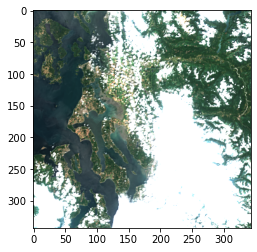

In [14]:
# GDAL gets a little unhappy with SSL access to Azure via SAS URLs in some situations;
# this fixes this issue.
#
# From:
# 
# http://gpsinfo.org/qgis-opening-remote-files-with-gdal-over-https-fails/    
import gdal 
gdal.SetConfigOption("GDAL_HTTP_UNSAFESSL", "YES")
gdal.VSICurlClearCache()

thumbnail_data = []

# url = rgb_urls[0]
for url in rgb_urls:
    
    # From:
    #
    # https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html
    with rasterio.open(url) as raster:
        
        # List of overviews from biggest to smallest
        oviews = raster.overviews(1)
    
        # Retrieve the smallest thumbnail
        decimation_level = oviews[-1]
        h = int(raster.height/decimation_level)
        w = int(raster.width/decimation_level)
        
        thumbnail_channel = raster.read(1, out_shape=(1, h, w)) / norm_value
        thumbnail_data.append(thumbnail_channel)

rgb = np.dstack((thumbnail_data[0],thumbnail_data[1],thumbnail_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Download support functions

In [15]:
max_path_len = 255

def download_url(url, destination_filename=None, progress_updater=None, force_download=False):
    """
    Download a URL to a temporary file
    """
    
    url_no_sas = url.split('?')[0]
        
    # This is not intended to guarantee uniqueness, we just know it happens to guarantee
    # uniqueness for this application.
    if destination_filename is None:
        # url_as_filename = url.replace('://', '_').replace('/', '_').replace('?','_').replace('&',
        url_without_sas = url.split('?', 1)[0]
        url_as_filename = re.sub(r'\W+', '', url_without_sas)
        n_folder_chars = len(temp_dir)
        if len(url_as_filename) + n_folder_chars > max_path_len:
            print('Warning: truncating filename target to {} characters'.format(max_path_len))
            url_as_filename = url_as_filename[-1*(max_path_len-n_folder_chars):]
        destination_filename = \
            os.path.join(temp_dir,url_as_filename)
        
    if (not force_download) and (os.path.isfile(destination_filename)):
        print('Bypassing download of already-downloaded file {}'.format(os.path.basename(url_no_sas)))
    else:
        print('Downloading file {} to {}'.format(os.path.basename(url_no_sas),destination_filename),end='')
        urllib.request.urlretrieve(url, destination_filename, progress_updater)  
        assert(os.path.isfile(destination_filename))
        nBytes = os.path.getsize(destination_filename)
        print('...done, {} bytes.'.format(nBytes))
    return destination_filename

### Download the whole files for our three bands of interest

In [17]:
filenames = []

for image_url in rgb_urls:
    fn = download_url(url=image_url,destination_filename=None)
    filenames.append(fn)

Bypassing download of already-downloaded file T10UEU_20190730T190919_B04_10m.tif
Bypassing download of already-downloaded file T10UEU_20190730T190919_B03_10m.tif
Bypassing download of already-downloaded file T10UEU_20190730T190919_B02_10m.tif


### Render

Resampling to 1098,1098
Resampling to 1098,1098
Resampling to 1098,1098


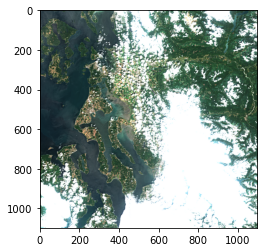

In [18]:
image_data = []

# fn = filenames[0]
for fn in filenames:
    with rasterio.open(fn,'r') as raster:
        h = int(raster.height/dsfactor)
        w = int(raster.width/dsfactor)
        print('Resampling to {},{}'.format(h,w))
        band_array = raster.read(1, out_shape=(1, h, w))
        raster.close()
        band_array = band_array / norm_value
        image_data.append(band_array)

rgb = np.dstack((image_data[0],image_data[1],image_data[2]))
np.clip(rgb,0,1,rgb)
plt.imshow(rgb)

### Clean up temporary files

In [19]:
shutil.rmtree(temp_dir)